# Import Libraries and Datasets

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from sklearn.metrics import confusion_matrix

# Import Datasets
df_cleaned_v5 = pd.read_csv('../data/processed/data_cleaned_v5.csv')

df = pd.read_csv('../data/processed/data_processed.csv')

# Create Function

In [67]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

# Calculate the accuracy, precision, recall, and F1 score
def get_test_metrics(y_test, y_pred, y_prob):
    accuracy = accuracy_score(y_test, y_pred)
    precision = precision_score(y_test, y_pred)
    recall = recall_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred)
    auc = roc_auc_score(y_test, y_prob)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'AUC: {auc:.4f}')

# Modeling (df_cleaned_v5)

## Stratified Train Test Split

In [78]:
X = df_cleaned_v5.drop(columns = ['FraudFound_P'])
y = df_cleaned_v5['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

## Modeling 

In [79]:
# Train a Balanced Bagging Classifier (base model: LGBM)
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = -1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred = balbag.predict(X_test)
y_prob = balbag.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.7043
Precision: 0.1508
Recall: 0.8486
F1 Score: 0.2561
AUC: 0.8250


## Use RFECV to select feature with LGBM

In [ ]:
# Use Undersampling first
rus = RandomUnderSampler(random_state = 42)
X_train_rus, y_train_rus = rus.fit_resample(X_train, y_train)

Accuracy: 0.9309
Precision: 0.2941
Recall: 0.1081
F1 Score: 0.1581
AUC: 0.8265


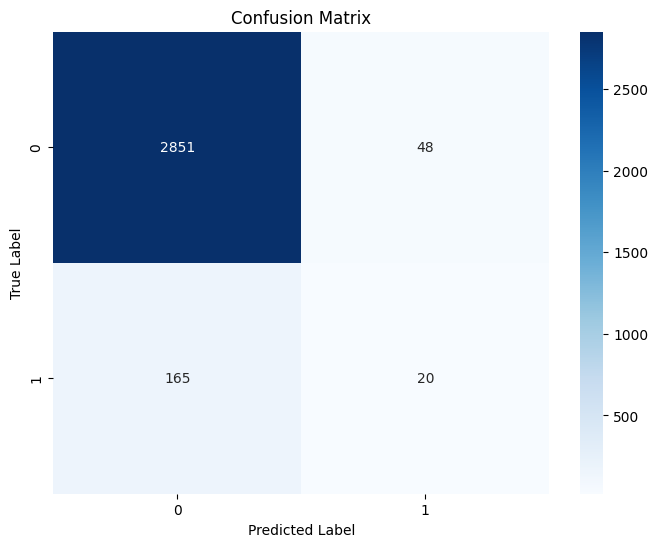

In [ ]:
lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
lgbm.fit(X_train_rus, y_train_rus)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

In [ ]:
from sklearn.feature_selection import RFECV
from sklearn.model_selection import StratifiedKFold
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
rfecv = RFECV(estimator = lgbm, step = 1, cv = StratifiedKFold(5), scoring = 'f1')
rfecv.fit(X_train_rus, y_train_rus)

RFECV(cv=StratifiedKFold(n_splits=5, random_state=None, shuffle=False),
      estimator=LGBMClassifier(random_state=42, verbose=-1), scoring='f1')

In [ ]:
print("Optimal number of features:", rfecv.n_features_)
print("Selected features:", rfecv.support_)
print("Feature ranking:", rfecv.ranking_)

Optimal number of features: 74
Selected features: [ True  True  True  True  True  True False  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False False False  True False  True  True  True  True
  True  True  True  True  True  True  True  True  True  True  True  True
  True  True  True False  True  True  True  True  True False  True  True
  True  True False  True False  True False  True  True  True  True  True]
Feature ranking: [ 1  1  1  1  1  1  5  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  7  6  4  1  8  1  1  1  1
  1  1  1  1  1  1  1  1  1  1  1  1  1  1  1  3  1  1  1  1  1 10  1  1
  1  1 11  1  9  1  2  1  1  1  1  1]


In [ ]:
X_train_rus_selected = rfecv.transform(X_train_rus)
X_test_selected = rfecv.transform(X_test)
X_train_rus_selected.shape

(23196, 74)

Accuracy: 0.9309
Precision: 0.3108
Recall: 0.1243
F1 Score: 0.1776
AUC: 0.8277


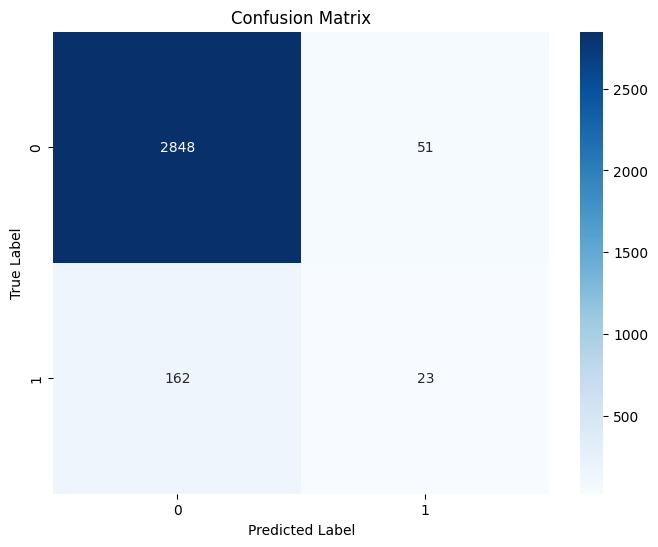

In [ ]:
lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
lgbm.fit(X_train_rus_selected, y_train_rus)
y_pred = lgbm.predict(X_test_selected)
y_prob = lgbm.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.9322
Precision: 0.3125
Recall: 0.1081
F1 Score: 0.1606
AUC: 0.7985


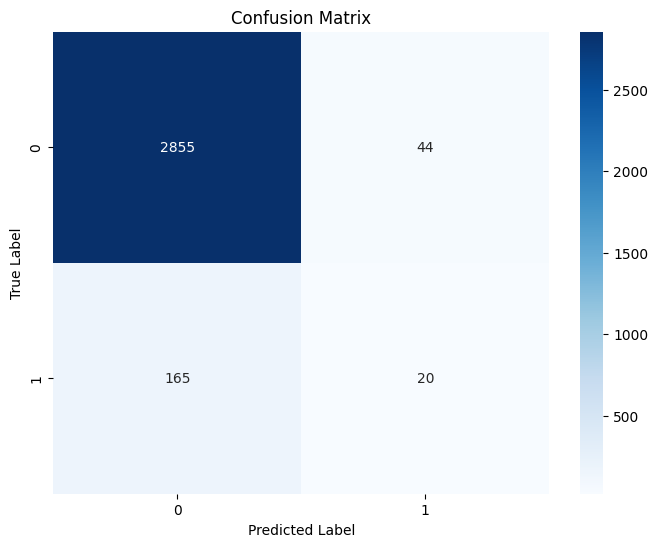

In [ ]:
# Train a Balanced Bagging Classifier
X_train_selected = rfecv.transform(X_train)
X_test_selected = rfecv.transform(X_test) 

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = -1, random_state = 42)

balbag.fit(X_train_selected, y_train)
y_pred = balbag.predict(X_test_selected)
y_prob = balbag.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.7866
Precision: 0.1276
Recall: 0.4378
F1 Score: 0.1976
AUC: 0.7567


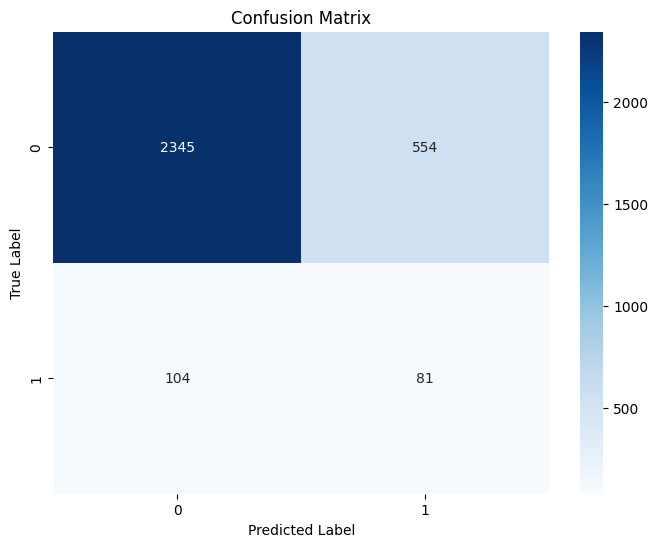

In [ ]:
# Train an EasyEnesmble Classifier
ee = EasyEnsembleClassifier(n_estimators=100, random_state = 42)
ee.fit(X_train_selected, y_train)
y_pred = ee.predict(X_test_selected)
y_prob = ee.predict_proba(X_test_selected)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

# Anomaly Detection (df_cleaned_v5)

In [ ]:
from sklearn.model_selection import train_test_split

df_train, df_valid = train_test_split(df_cleaned_v5, test_size=0.3, random_state=42, stratify=df_cleaned_v5['FraudFound_P'])
df_valid, df_test = train_test_split(df_valid, test_size=0.5, random_state=42, stratify=df_valid['FraudFound_P'])

In [ ]:
# 將訓練集分成正常樣本（多數類別）和異常樣本（少數類別）
df_train_normal = df_train[df_train['FraudFound_P'] == 0]
df_train_anomaly = df_train[df_train['FraudFound_P'] == 1]

# 分離特徵跟目標變數（非監督學習訓練時只用到正常樣本的特徵)
X_train_normal = df_train_normal.drop(columns = 'FraudFound_P')
y_trai_normal = df_train_normal['FraudFound_P']

X_valid = df_valid.drop(columns = 'FraudFound_P')
y_valid= df_valid['FraudFound_P']

X_test = df_test.drop(columns = 'FraudFound_P')
y_test= df_test['FraudFound_P']

In [ ]:
# 計算異常樣本的比例
df_train['FraudFound_P'].value_counts(normalize = True)

FraudFound_P
0    0.940152
1    0.059848
Name: proportion, dtype: float64

In [ ]:
from sklearn.ensemble import IsolationForest

iso_forest = IsolationForest(contamination=0.06, random_state=42)  

# 訓練模型（僅使用正常樣本）
iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.06, random_state=42)

In [ ]:
# 在驗證集上預測異常分數
y_valid_scores = iso_forest.decision_function(X_valid)  # 產生異常分數
y_valid_pred = iso_forest.predict(X_valid)

# 將預測結果轉為 0 和 1
# Isolation Forest 預測結果中，1 表示正常樣本，-1 表示異常樣本
y_valid_pred = [1 if x == -1 else 0 for x in y_valid_pred]  # 將 -1 轉為 1，表示異常

# 調整閾值（可以嘗試不同的閾值來優化指標，例如F1或AUC分數）
from sklearn.metrics import f1_score

# 計算驗證集上的 F1 和 AUC 分數
f1 = f1_score(y_valid, y_valid_pred)
print(f"Validation F1 Score: {f1}")

Validation F1 Score: 0.08609271523178808


In [ ]:
# 計算第 5 個分位數的閾值
threshold = np.percentile(y_valid_scores, 6)  # 5% 的分位數作為異常閾值
print(f"Selected anomaly threshold: {threshold}")

# 標記異常樣本
y_valid_pred = (y_valid_scores < threshold).astype(int)

Selected anomaly threshold: -0.003082487402918546


# Classification models (data_processed)

## Use Tree base model to select features

In [101]:
from sklearn.model_selection import train_test_split

X = df.drop(columns = ['FraudFound_P'])
y = df['FraudFound_P']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42, stratify = y)

In [102]:
from imblearn.under_sampling import RandomUnderSampler
rus = RandomUnderSampler(random_state = 42)
X_rus, y_rus = rus.fit_resample(X_train, y_train)

In [103]:
import lightgbm as lgb

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

lgbm.fit(X_rus, y_rus)
y_pred = lgbm.predict(X_test)
y_prob = lgbm.predict_proba(X_test)[:, 1]

get_test_metrics(y_test, y_pred, y_prob)

Accuracy: 0.7007
Precision: 0.1506
Recall: 0.8595
F1 Score: 0.2562
AUC: 0.8435


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/shap/explainers/_tree.py:448: UserWarning: LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray
  warnings.warn('LightGBM binary classifier with TreeExplainer shap values output has changed to a list of ndarray')


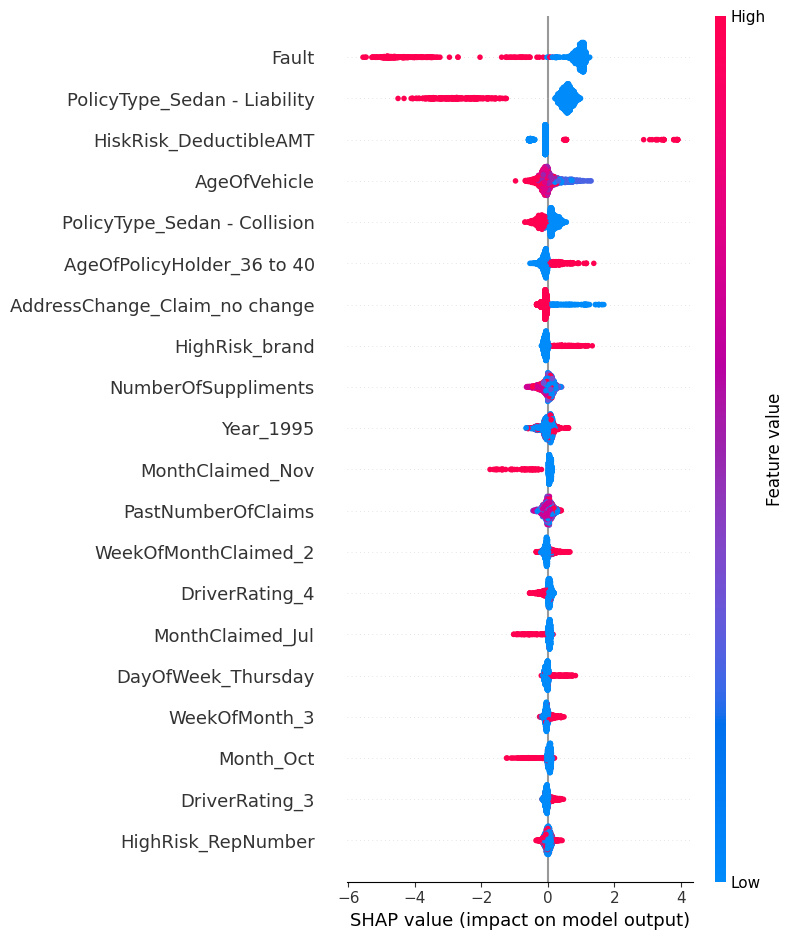

In [104]:
import numpy as np
import shap

# Create explainer object
explainer = shap.TreeExplainer(lgbm)

shap_values = explainer.shap_values(X_rus)
shap.summary_plot(shap_values, X_rus)  

# Get mean absolute SHAP values for each feature
shap_importance = pd.DataFrame({
    'Feature': X_rus.columns,
    'SHAP_importance': np.abs(shap_values).mean(axis=0)
})


# 先排序一次
sorted_features = shap_importance.sort_values('SHAP_importance', ascending=False)
# 創建特徵字典
feature_dict = {
    'top_20_features': sorted_features.head(20)['Feature'].tolist(),
    'top_30_features': sorted_features.head(30)['Feature'].tolist(),
    'top_40_features': sorted_features.head(40)['Feature'].tolist(),
    'top_50_features': sorted_features.head(50)['Feature'].tolist(),
    'top_60_features': sorted_features.head(60)['Feature'].tolist(),
    'top_70_features': sorted_features.head(70)['Feature'].tolist()
}

In [105]:
for feature_name, features in feature_dict.items():
    X_rus_selected = X_rus[features]
    X_test_selected = X_test[features]

    lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)

    lgbm.fit(X_rus_selected, y_rus)
    y_pred = lgbm.predict(X_test_selected)
    y_prob = lgbm.predict_proba(X_test_selected)[:, 1]

    print(f"\nResults for {feature_name}:")
    get_test_metrics(y_test, y_pred, y_prob)


Results for top_20_features:
Accuracy: 0.6777
Precision: 0.1333
Recall: 0.7946
F1 Score: 0.2283
AUC: 0.8028

Results for top_30_features:
Accuracy: 0.6868
Precision: 0.1401
Recall: 0.8216
F1 Score: 0.2394
AUC: 0.8216

Results for top_40_features:
Accuracy: 0.6907
Precision: 0.1417
Recall: 0.8216
F1 Score: 0.2417
AUC: 0.8315

Results for top_50_features:
Accuracy: 0.7023
Precision: 0.1493
Recall: 0.8432
F1 Score: 0.2537
AUC: 0.8357

Results for top_60_features:
Accuracy: 0.7059
Precision: 0.1495
Recall: 0.8324
F1 Score: 0.2535
AUC: 0.8419

Results for top_70_features:
Accuracy: 0.7108
Precision: 0.1524
Recall: 0.8378
F1 Score: 0.2579
AUC: 0.8436


## Ensemble models

In [106]:
# 使用30個features，在模型表現及複雜度之間取得一個較好的平衡
X = df.drop(columns = ['FraudFound_P'])
X_selected = X[feature_dict['top_30_features']]
y = df['FraudFound_P']

# 將train, validation, test data 切成 70%, 15%, 15%
X_train, X_temp, y_train, y_temp = train_test_split(X_selected, y, test_size = 0.3, random_state = 42, stratify = y)
X_valid, X_test, y_valid, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=42, stratify=y_temp)

In [107]:
# Train a Balanced Bagging Classifier (base model: LGBM)
import lightgbm as lgb
from imblearn.ensemble import BalancedBaggingClassifier

lgbm = lgb.LGBMClassifier(n_estimators=100, learning_rate=0.1, random_state=42, verbose=-1)
balbag = BalancedBaggingClassifier(estimator = lgbm, n_estimators=100, bootstrap = True,
                                   bootstrap_features = True, sampling_strategy = 'majority', replacement = True,
                                   n_jobs = -1, random_state = 42)

balbag.fit(X_train, y_train)
y_pred = balbag.predict(X_valid)
y_prob = balbag.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)

Accuracy: 0.7307
Precision: 0.1592
Recall: 0.8129
F1 Score: 0.2662
AUC: 0.8332


In [108]:
# Train a Balanced Random Foresr model
from imblearn.ensemble import BalancedRandomForestClassifier

brf = BalancedRandomForestClassifier(n_estimators=100, random_state=42)
brf.fit(X_train, y_train)
y_pred = brf.predict(X_valid)
y_prob = brf.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_test)


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:577: FutureWarning: The default of `sampling_strategy` will change from `'auto'` to `'all'` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `'all'` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:589: FutureWarning: The default of `replacement` will change from `False` to `True` in version 0.13. This change will follow the implementation proposed in the original paper. Set to `True` to silence this warning and adopt the future behaviour.
  warn(
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/imblearn/ensemble/_forest.py:601: FutureWarning: The default of `bootstrap` will change from `True` to `False` in version 0.13. This change will follow 

Accuracy: 0.6412
Precision: 0.1359
Recall: 0.9281
F1 Score: 0.2371
AUC: 0.5065


In [109]:
# Train an EasyEnsemble Classifier
from imblearn.ensemble import EasyEnsembleClassifier

ee = EasyEnsembleClassifier(n_estimators=100, random_state=42)
ee.fit(X_train, y_train)
y_pred = ee.predict(X_valid)
y_prob = ee.predict_proba(X_valid)[:, 1]

get_test_metrics(y_valid, y_pred, y_prob)


Accuracy: 0.5949
Precision: 0.1243
Recall: 0.9496
F1 Score: 0.2198
AUC: 0.8058


在三個模型中，由Balanced Bagging Classifier在AUC表現較好，在Recall有0.8以上，precision也有0.15以上，取得一個不錯的平衡。  
下面會選擇較符合詐欺偵測適合的閾值。


In [110]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 0.9, 50)

best_threshold = 0.5  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (y_prob >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted)
    recall = recall_score(y_valid, y_pred_adjusted)
    f1 = f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.12, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.13, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.15, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.17, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.18, Precision: 0.0604, Recall: 1.0000, F1-score: 0.1140
Threshold: 0.20, Precision: 0.0617, Recall: 1.0000, F1-score: 0.1162
Threshold: 0.21, Precision: 0.0623, Recall: 1.0000, F1-score: 0.1173
Threshold: 0.23, Precision: 0.0623, Recall: 1.0000, F1-score: 0.1173
Threshold: 0.25, Precision: 0.0623, Recall: 1.0000, F1-score: 0.1173
Threshold: 0.26, Precision: 0.0623, Recall: 1.0000, F1-score: 0.1173
Threshold: 0.28, Precision: 0.0624, Recall: 1.0000, F1-score: 0.1174
Threshold: 0.30, Precision: 0.0632, Recall: 1.0000, F1-score: 0.1189
Threshold: 0.31, Precision: 0.0666, Recall: 1.0000, F1-score: 0.1248
Threshold: 0.33, Precision: 0.0714

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this beh

我選擇 0.41作為threshold，因為在詐欺偵測的問題中，False negative成本通常比False positive高上許多，  
因此在這個threshold下，能夠捕捉90%以上的詐欺案件，精確率為13.22%。  

將這個閾值及模型運用在test data上

In [111]:
# 使用0.41閾值預測test data
y_test_prob = ee.predict_proba(X_test)[:, 1]
y_test_pred = (y_test_prob >= 0.41).astype(int)

# 取得測試集的評估指標
get_test_metrics(y_test, y_test_pred, y_test_prob)


Accuracy: 0.5884
Precision: 0.1217
Recall: 0.9493
F1 Score: 0.2158
AUC: 0.7869


In [112]:
top_20_features

['Fault',
 'PolicyType_Sedan - Liability',
 'HiskRisk_DeductibleAMT',
 'AgeOfVehicle',
 'PolicyType_Sedan - Collision',
 'AgeOfPolicyHolder_36 to 40',
 'AddressChange_Claim_no change',
 'HighRisk_brand',
 'NumberOfSuppliments',
 'Year_1995',
 'MonthClaimed_Nov',
 'PastNumberOfClaims',
 'WeekOfMonthClaimed_2',
 'DriverRating_4',
 'MonthClaimed_Jul',
 'DayOfWeek_Thursday',
 'WeekOfMonth_3',
 'Month_Oct',
 'DriverRating_3',
 'HighRisk_RepNumber']

# Anomaly Detection (data_processed)

## Isolation Forest

In [117]:
# 先結合X_train與y_train，因為異常偵測算法只使用正常資料訓練
df_train = pd.concat([X_train, pd.DataFrame(y_train, columns=['FraudFound_P'])], axis = 1)

# 將訓練集分成正常樣本（多數類別）和異常樣本（少數類別）
df_train_normal = df_train[df_train['FraudFound_P'] == 0]
df_train_anomaly = df_train[df_train['FraudFound_P'] == 1]

# 分離特徵跟目標變數（非監督學習訓練時只用到正常樣本的特徵)
X_train_normal = df_train_normal.drop(columns = 'FraudFound_P')

In [118]:
from sklearn.ensemble import IsolationForest

# 詐欺樣本比例為6%，contimination設為0.06
iso_forest = IsolationForest(contamination=0.06, random_state=42)  

# 訓練模型（僅使用正常樣本）
iso_forest.fit(X_train_normal)

IsolationForest(contamination=0.06, random_state=42)

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


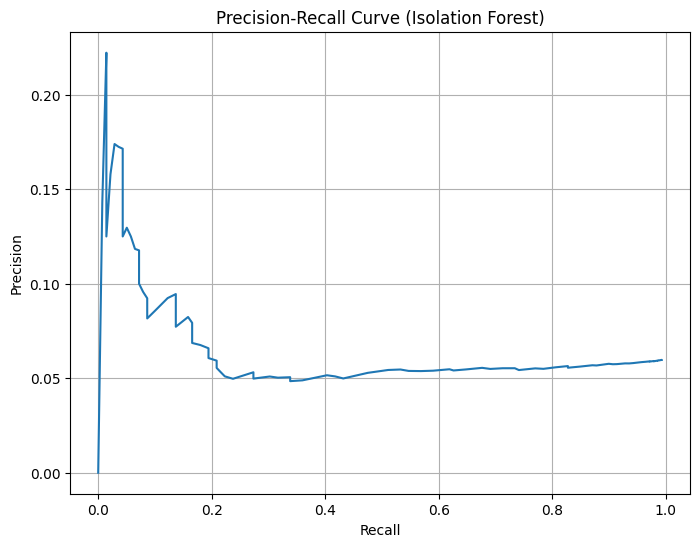

In [122]:
# 在驗證集上預測異常分數
y_valid_scores = iso_forest.decision_function(X_valid)  # 產生異常分數

# 計算不同閾值下的precision和recall
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 100)
precisions = []
recalls = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算precision和recall
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# 繪製precision-recall曲線
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.grid(True)
plt.show()


## One-Class SVM

In [124]:
from sklearn.svm import OneClassSVM

OSVM = OneClassSVM(kernel='rbf', gamma=0.1, nu=0.1)
OSVM.fit(X_train_normal)

OneClassSVM(gamma=0.1, nu=0.1)

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


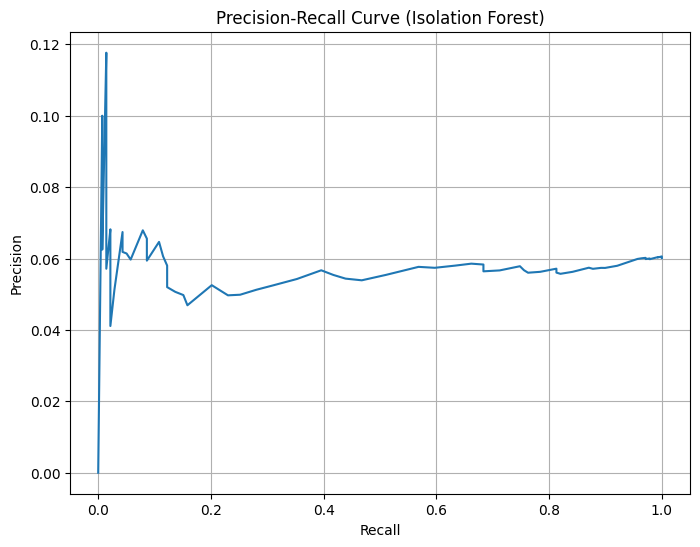

In [125]:
y_valid_scores = OSVM.decision_function(X_valid) #產生異常分數

# 計算不同閾值下的precision和recall
thresholds = np.linspace(y_valid_scores.min(), y_valid_scores.max(), 100)
precisions = []
recalls = []

for threshold in thresholds:
    # 將異常分數轉換為預測標籤 (小於閾值為異常=1，大於閾值為正常=0)
    y_pred = (y_valid_scores < threshold).astype(int)
    
    # 計算precision和recall
    precision = precision_score(y_valid, y_pred)
    recall = recall_score(y_valid, y_pred)
    
    precisions.append(precision)
    recalls.append(recall)

# 繪製precision-recall曲線
plt.figure(figsize=(8, 6))
plt.plot(recalls, precisions)
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Isolation Forest)')
plt.grid(True)
plt.show()

## AutoEncoders

In [127]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from sklearn.preprocessing import StandardScaler

# Scale the data
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_normal)
X_valid_scaled = scaler.transform(X_valid)

# Build autoencoder model
input_dim = X_train_scaled.shape[1]

autoencoder = Sequential([
    # Encoder
    Dense(32, activation='relu', input_shape=(input_dim,)),
    Dense(16, activation='relu'),
    Dense(8, activation='relu'),
    
    # Decoder
    Dense(16, activation='relu'),
    Dense(32, activation='relu'),
    Dense(input_dim, activation='sigmoid')
])

autoencoder.compile(optimizer='adam', loss='mse')


/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [128]:
# Train the model
history = autoencoder.fit(
    X_train_scaled, 
    X_train_scaled,
    epochs=50,
    batch_size=32,
    shuffle=True,
    validation_data=(X_valid_scaled, X_valid_scaled),
    verbose=1
)

# Get reconstruction error
train_pred = autoencoder.predict(X_train_scaled)
valid_pred = autoencoder.predict(X_valid_scaled)

train_mse = np.mean(np.power(X_train_scaled - train_pred, 2), axis=1)
valid_mse = np.mean(np.power(X_valid_scaled - valid_pred, 2), axis=1)

Epoch 1/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 1s 853us/step - loss: 1.0910 - val_loss: 0.9290
Epoch 2/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 634us/step - loss: 0.9068 - val_loss: 0.8689
Epoch 3/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 586us/step - loss: 0.8572 - val_loss: 0.8530
Epoch 4/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 584us/step - loss: 0.8498 - val_loss: 0.8273
Epoch 5/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 602us/step - loss: 0.8264 - val_loss: 0.8123
Epoch 6/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 600us/step - loss: 0.8061 - val_loss: 0.7999
Epoch 7/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 623us/step - loss: 0.7934 - val_loss: 0.7926
Epoch 8/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 580us/step - loss: 0.7848 - val_loss: 0.7872
Epoch 9/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 697us/step - loss: 0.7846 - val_loss: 0.7855
Epoch 10/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 569us/step - loss: 0.7821 - val_loss: 0.7835
Epoch 11/50
318/318 ━━━━━━━━━━━━━━━━━━━━ 0s 576us/step - loss: 0.7765 - val_loss: 0.7818
Epoch 12/50
318/318 ━━━━━━━━━━

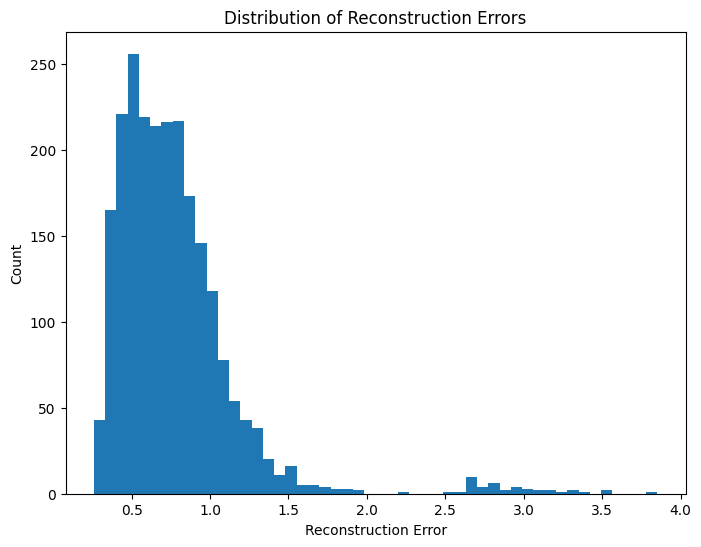

In [130]:
# Plot reconstruction error distribution
plt.figure(figsize=(8, 6))
plt.hist(valid_mse, bins=50)
plt.xlabel('Reconstruction Error')
plt.ylabel('Count')
plt.title('Distribution of Reconstruction Errors')
plt.show()

In [134]:
# 設定閾值範圍
thresholds = np.linspace(0.1, 4.0, 50)

best_threshold = 0.1  # 初始閾值
best_f1 = 0

for threshold in thresholds:
    y_pred_adjusted = (valid_mse >= threshold).astype(int)
    precision = precision_score(y_valid, y_pred_adjusted)
    recall = recall_score(y_valid, y_pred_adjusted)
    f1 = f1_score(y_valid, y_pred_adjusted)
    print(f"Threshold: {threshold:.2f}, Precision: {precision:.4f}, Recall: {recall:.4f}, F1-score: {f1:.4f}")
    # 更新最佳閾值
    if f1 > best_f1:
        best_f1 = f1
        best_threshold = threshold

print(f"\nBest Threshold: {best_threshold:.2f}, Best F1-score: {best_f1:.4f}")

Threshold: 0.10, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.18, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.26, Precision: 0.0601, Recall: 1.0000, F1-score: 0.1134
Threshold: 0.34, Precision: 0.0597, Recall: 0.9712, F1-score: 0.1125
Threshold: 0.42, Precision: 0.0569, Recall: 0.8489, F1-score: 0.1066
Threshold: 0.50, Precision: 0.0543, Recall: 0.7050, F1-score: 0.1009
Threshold: 0.58, Precision: 0.0542, Recall: 0.5971, F1-score: 0.0995
Threshold: 0.66, Precision: 0.0486, Recall: 0.4532, F1-score: 0.0879
Threshold: 0.74, Precision: 0.0483, Recall: 0.3669, F1-score: 0.0854
Threshold: 0.82, Precision: 0.0521, Recall: 0.3022, F1-score: 0.0889
Threshold: 0.90, Precision: 0.0570, Recall: 0.2518, F1-score: 0.0930
Threshold: 0.98, Precision: 0.0554, Recall: 0.1799, F1-score: 0.0847
Threshold: 1.06, Precision: 0.0681, Recall: 0.1583, F1-score: 0.0952
Threshold: 1.13, Precision: 0.0684, Recall: 0.1151, F1-score: 0.0858
Threshold: 1.21, Precision: 0.0843

/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/Users/samlai/Documents/Vehicle_insurance_claim_project/myenv/lib/python3.12/site-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 due to no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
